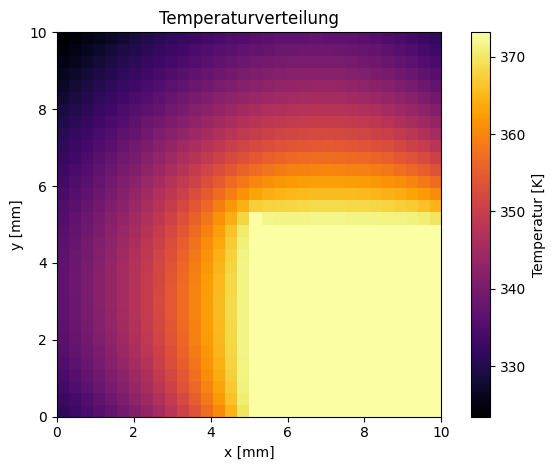

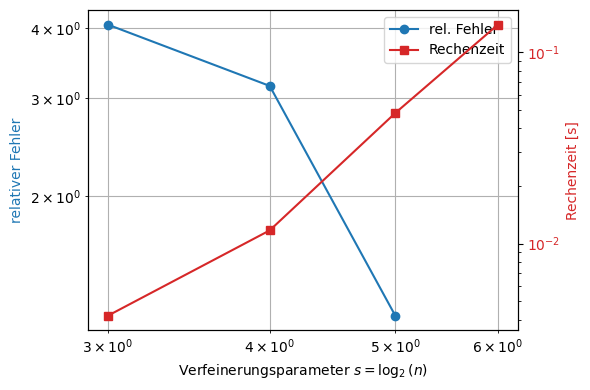

In [8]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import time

# ---------- globale Konstanten -----------------
T_CU   = 373.15          # Kupfer-Temperatur [K]
T_PVC  = 294.15          # PVC-Temperatur / Raumtemp. [K]
LAM_CU = 380.0           # λ_Cu  [W m⁻¹ K⁻¹]
LAM_PVC = 0.23           # λ_PVC [W m⁻¹ K⁻¹]
h_PVC  = 23.0            # Wärmeübergangskoeff. [W m⁻² K⁻¹]
T_inf  = 294.15          # Umgebung [K]
L      = 0.01            # Plattenlänge 10 mm → 0,01 m

# optionale konstanter Wärmestrom (Neumann) am Südrand
q_neu_sued = None       
def harmonic_mean(a, b):           
    return 2 * a * b / (a + b) if (a + b) else 0.0

def gid(i, j, n):                 
    return i * n + j

# =========== Systemmatrix A & Quellenvektor S ===============
def build_system(n: int):
    dx = dy = L / n
    N  = n * n
    A  = sp.lil_matrix((N, N))
    S  = np.zeros(N)

    # --- Materialmatrix ------------------------------------
    lam = np.full((n, n), LAM_PVC)
    lam[: n // 2, n // 2 :] = LAM_CU  # ober-rechts = Cu

    # --- Dirichlet-Maske -----------------------------------
    D = np.zeros((n, n), dtype=bool)
    Dval = np.full((n, n), T_PVC)
    D[: n // 2, n // 2 :] = True      # Randvol. Cu 100 °C
    Dval[: n // 2, n // 2 :] = T_CU
    m = n // 2                        # innerer Punkt T10
    D[m, m]  = True
    Dval[m, m] = T_CU

    # --- Schleife über alle CV -----------------------------
    for i in range(n):
        for j in range(n):
            p = gid(i, j, n)

            if D[i, j]:               # Dirichlet: 1-Gleichung
                A[p, p] = 1.0
                S[p]    = Dval[i, j]
                continue

            aP = 0.0

            # Osten (E)
            if j < n - 1:
                aE = harmonic_mean(lam[i, j], lam[i, j + 1]) / dx**2
                A[p, gid(i, j + 1, n)] = -aE
                aP += aE
            else:                     # Ost-Rand
                if i >= n // 2:       # nur untere PVC-Hälfte
                    aP += h_PVC / dx
                    S[p] += h_PVC / dx * T_inf

            # Westen (W)
            if j > 0:
                aW = harmonic_mean(lam[i, j], lam[i, j - 1]) / dx**2
                A[p, gid(i, j - 1, n)] = -aW
                aP += aW
            else:                     # West-Rand (Cauchy)
                aP += h_PVC / dx
                S[p] += h_PVC / dx * T_inf

            # Norden (N)
            if i > 0:
                aN = harmonic_mean(lam[i, j], lam[i - 1, j]) / dy**2
                A[p, gid(i - 1, j, n)] = -aN
                aP += aN
            else:                     # Nord-Rand
                if j < n // 2:        # linke PVC-Hälfte
                    aP += h_PVC / dy
                    S[p] += h_PVC / dy * T_inf

            # Süden (S)
            if i < n - 1:
                aS = harmonic_mean(lam[i, j], lam[i + 1, j]) / dy**2
                A[p, gid(i + 1, j, n)] = -aS
                aP += aS
            else:                     # Süd-Rand
                if q_neu_sued is not None:         # Neumann
                    S[p] += q_neu_sued * dx
                else:                              # Cauchy
                    aP += h_PVC / dy
                    S[p] += h_PVC / dy * T_inf

            A[p, p] = aP

    return A.tocsr(), S

# =========== Solver ========================================
def solve_T(n, probe_pts):
    A, S = build_system(n)
    Tvec = spla.spsolve(A, S)
    Tmat = Tvec.reshape((n, n))

    # Probe-Punkte (relative Koords 0–1) → Temperaturwerte
    vals = []
    for x_rel, y_rel in probe_pts:
        i = int(round(y_rel * n - 0.5))
        j = int(round(x_rel * n - 0.5))
        i = min(max(i, 0), n - 1)
        j = min(max(j, 0), n - 1)
        vals.append(Tmat[i, j])
    return vals, Tmat

# =========== Plot-Funktionen ===============================
def plot_T(Tmat):
    plt.figure()
    plt.imshow(Tmat, origin='lower', cmap='inferno',
               extent=[0, 10, 0, 10])
    plt.colorbar(label='Temperatur [K]')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.title('Temperaturverteilung')
    plt.tight_layout()
    plt.show()

def gitteranalyse():
    import time
    import numpy as np
    import matplotlib.pyplot as plt

    # ---------- Konfig ------------------------------------
    messpunkte = [(0.2, 0.2), (0.4, 0.4),
                  (0.6, 0.4), (0.3, 0.7), (0.7, 0.7)]
    n_list = [8, 16, 32, 64]          # Testgitter
    T_samples, times = [], []

    # ---------- Simulationen ------------------------------
    for n in n_list:
        t0 = time.time()
        vals, _ = solve_T(n, messpunkte)
        times.append(time.time() - t0)
        T_samples.append(vals)

    # ---------- Fehlervektor ------------------------------
    T_ref = np.array(T_samples[-1])   # n=64 als Referenz
    err_vec = [np.linalg.norm(np.array(v) - T_ref) 
               for v in T_samples[:-1]]
    s_list  = [np.log2(n) for n in n_list]          # x-Achse
    err_arr = np.array(err_vec)                    # links
    time_arr = np.array(times)                     # rechts

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # linke Y-Achse: Fehler
    ax1.loglog(s_list[:-1], err_arr, 'o-', color='tab:blue', label='rel. Fehler')
    ax1.set_xticks([3,4,5,6]) ; ax1.set_xticklabels(['$3$','$4$','$5$','$6$'])
    ax1.set_xlabel(r"Verfeinerungsparameter $s=\log_2(n)$")
    ax1.set_ylabel("relativer Fehler", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True, which='both')

    # rechte Y-Achse: Rechenzeit
    ax2 = ax1.twinx()
    ax2.loglog(s_list, time_arr, 's-', color='tab:red', label='Rechenzeit')
    ax2.set_ylabel("Rechenzeit [s]", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Legende (optional)
    lines  = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

    fig.tight_layout()
    fig.savefig("gitteranalyse.png", dpi=300)
    plt.show()
# =========== Haupt-Ausführung ==============================
if __name__ == "__main__":
    # Einzellauf n=32
    vals, Tfield = solve_T(32, [(0.3, 0.3)])
    plot_T(Tfield)

    # Gitterkonvergenz
    gitteranalyse()